# APM Project

In [91]:
#Import Statements

#basic
import pandas as pd
import numpy as np
from math import log,exp
import math

#visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn

% pylab inline

#sklearn
from sklearn import model_selection
from sklearn.cluster import KMeans
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor)
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import (mean_squared_error, confusion_matrix,accuracy_score, make_scorer)
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import KFold

#MARS
import pyearth
from pyearth import Earth

#other stats & clustering
from scipy import stats
from patsy import dmatrices
from collections import Counter
from scipy.spatial.distance import cdist,pdist


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## DATA PRE-PROCESSING

In [79]:
def preprocess(df):
    
    # Feature engineering for categorical variables captured as numbers
    # Turn MSSubClass into factors
    code = ['20', '30', '40', '45', '50', '60', '70', '75', '80', '85', '90', '120', '150', '160', '180', '190']
    strings = ['1-STORY 1946 & NEWER ALL STYLES', '1-STORY 1945 & OLDER', '1-STORY W/FINISHED ATTIC ALL AGES', '1-1/2 STORY - UNFINISHED ALL AGES',\
     '1-1/2 STORY FINISHED ALL AGES', '2-STORY 1946 & NEWER', '2-STORY 1945 & OLDER', '2-1/2 STORY ALL AGES', \
     'SPLIT OR MULTI-LEVEL', 'SPLIT FOYER', 'DUPLEX - ALL STYLES AND AGES', '1-STORY PUD (Planned Unit Development) - 1946 & NEWER',\
     '1-1/2 STORY PUD - ALL AGES', '2-STORY PUD - 1946 & NEWER', 'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER', \
     '2 FAMILY CONVERSION - ALL STYLES AND AGES']

    MSSubClass=dict(zip(code,strings))
    df['MSSubClass']=[MSSubClass[str(val)] for val in df['MSSubClass']]

    # Turn month sold into factors
    months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']
    df['MoSold'] = df['MoSold'].replace(to_replace = df['MoSold'].value_counts().index.sort_values(),value=months)
    
    # Feature engineering for age-related variables
    # Convert yearsold vs yearbuilt into age of house
    df['Age'] =  df['YrSold'] - df['YearBuilt']
    df = df.drop('YearBuilt', 1)
    # Convert yearsold vs. yearreomdadd into age of remodel. Adding 2 to eliminate any negative or 0 values
    df['AgeRem'] = (df['YrSold'] - df['YearRemodAdd'])+2
    df = df.drop('YearRemodAdd', 1)
    # Remove age of garage - many missing values (if no garage)
    #  no additional valuable information (garage captured in other variables); age of house more important for age
    df = df.drop('GarageYrBlt', 1)
    df = df.drop('Id',1)
    
    # Fill select variables with most common / mode where logical
    # Most masonry veneer type is None and area is 0
    df['MasVnrType'] = df['MasVnrType'].fillna('None')
    df['MasVnrArea'] = df['MasVnrArea'].fillna(0.0)
    # Most electrical is 'SBrkr'
    df['Electrical'] = df['Electrical'].fillna('SBrkr')
    df['LotFrontage'] = df['LotFrontage'].fillna(mean(df['LotFrontage']))
    
    return df

In [80]:
def preprocess_withOutsideData(df):
    
    # Feature engineering for categorical variables captured as numbers
    # Turn MSSubClass into factors
    code = ['20', '30', '40', '45', '50', '60', '70', '75', '80', '85', '90', '120', '150', '160', '180', '190']
    strings = ['1-STORY 1946 & NEWER ALL STYLES', '1-STORY 1945 & OLDER', '1-STORY W/FINISHED ATTIC ALL AGES', '1-1/2 STORY - UNFINISHED ALL AGES',\
     '1-1/2 STORY FINISHED ALL AGES', '2-STORY 1946 & NEWER', '2-STORY 1945 & OLDER', '2-1/2 STORY ALL AGES', \
     'SPLIT OR MULTI-LEVEL', 'SPLIT FOYER', 'DUPLEX - ALL STYLES AND AGES', '1-STORY PUD (Planned Unit Development) - 1946 & NEWER',\
     '1-1/2 STORY PUD - ALL AGES', '2-STORY PUD - 1946 & NEWER', 'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER', \
     '2 FAMILY CONVERSION - ALL STYLES AND AGES']

    MSSubClass=dict(zip(code,strings))
    df['MSSubClass']=[MSSubClass[str(val)] for val in df['MSSubClass']]

    # Turn month sold into factors
    months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']
    df['MoSold'] = df['MoSold'].replace(to_replace = df['MoSold'].value_counts().index.sort_values(),value=months)
    
    # Feature engineering for age-related variables
    # Convert yearsold vs yearbuilt into age of house
    df['Age'] =  df['YrSold'] - df['YearBuilt']
    df = df.drop('YearBuilt', 1)
    # Convert yearsold vs. yearreomdadd into age of remodel. Adding 2 to eliminate any negative or 0 values
    df['AgeRem'] = (df['YrSold'] - df['YearRemodAdd'])+2
    df = df.drop('YearRemodAdd', 1)
    # Remove age of garage - many missing values (if no garage)
    #  no additional valuable information (garage captured in other variables); age of house more important for age
    df = df.drop('GarageYrBlt', 1)
    df = df.drop('Id',1)
    
    # Fill select variables with most common / mode where logical
    # Most masonry veneer type is None and area is 0
    df['MasVnrType'] = df['MasVnrType'].fillna('None')
    df['MasVnrArea'] = df['MasVnrArea'].fillna(0.0)
    # Most electrical is 'SBrkr'
    df['Electrical'] = df['Electrical'].fillna('SBrkr')
    df['LotFrontage'] = df['LotFrontage'].fillna(mean(df['LotFrontage']))
    
    ## Outside Data - Neighborhood Income Data
    neighb_incomedata=pd.read_csv('data/Neighborhood_Income.csv')
    neighb_incomedata['Rating']=neighb_incomedata['Rating'].map(lambda x: 'NeighbIncomeTier'+str(x))
    incomerating_dict=dict(zip(neighb_incomedata['Neighborhood'],neighb_incomedata['Rating']))
    df['NeighbIncomeRating']=df['Neighborhood'].map(lambda x:incomerating_dict[x])
    
    ## Outside Data - Census Data
    #ImportData
    census_AgeAndSex=pd.read_csv('data/AgeAndSex.csv')
    census_EmploymentStatus=pd.read_csv('data/EmploymentStatus.csv')
    census_FinancialCharacteristics=pd.read_csv('data/FinancialCharacteristics.csv')
    census_HouseholdsAndFamilies=pd.read_csv('data/HouseholdsAndFamilies.csv')
    census_Income=pd.read_csv('data/Income.csv')
    #GetMeasures
    MaleToFemaleRatio=census_AgeAndSex.ix[2,1:].astype(float)/census_AgeAndSex.ix[4,1:].astype(float)
    AgeDependencyRatio=census_AgeAndSex.ix[186,1:].astype(float)
    OldAgeDependencyRatio=census_AgeAndSex.ix[192,1:].astype(float)
    UnemploymentRate=census_EmploymentStatus.ix[7,1:].astype(float)
    PrimeWorkingAgeEmployed=census_EmploymentStatus.ix[28,1:].astype(float)
    OwnerToRenterRatio=census_FinancialCharacteristics.ix[2,1:].astype(float)/census_FinancialCharacteristics.ix[4,1:].astype(int)
    OwnerMonthlyHousingCostsIn00s=census_FinancialCharacteristics.ix[164,1:].astype(float)/100
    AvgHouseholdSize=census_HouseholdsAndFamilies.ix[10,1:].astype(float)
    PctFamilyHouseholds=census_HouseholdsAndFamilies.ix[2,1:].astype(float)/census_HouseholdsAndFamilies.ix[0,1:].astype(float)
    SingleMaleToFemaleHouseholdsRatio=census_HouseholdsAndFamilies.ix[4,1:].astype(float)/census_HouseholdsAndFamilies.ix[6,1:].astype(float)
    PctLivingAlone=census_HouseholdsAndFamilies.ix[110,1:].astype(float)/100
    TenureOwnerToRenterRatio=census_HouseholdsAndFamilies.ix[180,1:].astype(float)/census_HouseholdsAndFamilies.ix[190,1:].astype(float)
    PctLessThan15k=(census_Income.ix[8,1:].astype(float)+census_Income.ix[16,1:].astype(float))/100
    Pct15kto25k=(census_Income.ix[24,1:].astype(float))/100
    Pct25kto35k=(census_Income.ix[32,1:].astype(float))/100
    Pct35kto50k=(census_Income.ix[40,1:].astype(float))/100
    Pct50kto75k=(census_Income.ix[48,1:].astype(float))/100
    Pct75kto100k=(census_Income.ix[56,1:].astype(float))/100
    Pct100kto200k=(census_Income.ix[64,1:].astype(float)+census_Income.ix[72,1:].astype(float))/100
    PctOver200k=(census_Income.ix[80,1:].astype(float))/100
    MedIncomeIn000s=(census_Income.ix[88,1:].astype(float))/1000
    MeanToMedIncomeRatio=(census_Income.ix[96,1:].astype(float))/(census_Income.ix[88,1:].astype(float))
    #GetYears
    Yr2006=(df['YrSold']==2006)*1
    Yr2007=(df['YrSold']==2007)*1
    Yr2008=(df['YrSold']==2008)*1
    Yr2009=(df['YrSold']==2009)*1
    Yr2010=(df['YrSold']==2010)*1
    #AddToDataframe
    AnnualMeasures=[MaleToFemaleRatio,AgeDependencyRatio,OldAgeDependencyRatio,UnemploymentRate,PrimeWorkingAgeEmployed,
                    OwnerToRenterRatio,OwnerMonthlyHousingCostsIn00s,AvgHouseholdSize,PctFamilyHouseholds,
                    SingleMaleToFemaleHouseholdsRatio,PctLivingAlone,TenureOwnerToRenterRatio,PctLessThan15k,
                    Pct15kto25k,Pct25kto35k,Pct35kto50k,Pct50kto75k,Pct75kto100k,Pct100kto200k,PctOver200k,
                    MedIncomeIn000s,MeanToMedIncomeRatio]
    MeasuresNames=['MaleToFemaleRatio','AgeDependencyRatio','OldAgeDependencyRatio','UnemploymentRate','PrimeWorkingAgeEmployed',
                   'OwnerToRenterRatio','OwnerMonthlyHousingCostsIn00s','AvgHouseholdSize','PctFamilyHouseholds',
                   'SingleMaleToFemaleHouseholdsRatio','PctLivingAlone','TenureOwnerToRenterRatio','PctLessThan15k',
                   'Pct15kto25k','Pct25kto35k','Pct35kto50k','Pct50kto75k','Pct75kto100k','Pct100kto200k','PctOver200k',
                   'MedIncomeIn000s','MeanToMedIncomeRatio']
    for i in range(len(AnnualMeasures)):
        M_2006=AnnualMeasures[i][0]*Yr2006
        M_2007=AnnualMeasures[i][1]*Yr2007
        M_2008=AnnualMeasures[i][2]*Yr2008
        M_2009=AnnualMeasures[i][3]*Yr2009
        M_2010=AnnualMeasures[i][4]*Yr2010
        M_Total=M_2006+M_2007+M_2008+M_2009+M_2010
        colname=MeasuresNames[i]
        df[colname]=M_Total
    
    
    return df

In [81]:
def get_dummies(X_df):
    # Dummify X data
    X_dummy = pd.get_dummies(X_df,dummy_na=True)
    return X_dummy

In [82]:
def level_cat(df_train,df_comp):
    traincols = list(df_train.columns.values)
    testcols = list(df_comp.columns.values)
    
    # Align train data columns to competition data columns
    missingcols1 = list(set(testcols)-set(traincols))
    for col in missingcols1:
        df_train[col] = 0.0

    # Align test data columns to competition data columns
    missingcols = list(set(traincols)-set(testcols))
    for col in missingcols:
        df_comp[col] = 0.0
    df_comp = df_comp[traincols+missingcols1]
    
    return df_train,df_comp

In [83]:
housedata = preprocess_withOutsideData(pd.read_csv('train.csv'))
# Split into X and y
y = housedata['SalePrice']
X = housedata.drop('SalePrice', 1)

#preprocess and dummify competition
X = get_dummies(X)
competition = preprocess_withOutsideData(pd.read_csv('test.csv'))
X_comp = get_dummies(competition)

X,X_comp = level_cat(X,X_comp)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33, random_state=1)

## MODELING

### Initital Model Exploration (MLR, Lasso, Ridge, MLP)

In [9]:
# Run models
#Linear Regression
MLR =LinearRegression()
model_MLR = MLR.fit(X_train,y_train)
MLR_predict_reg = model_MLR.predict(X_test)
MLR_RMSE_reg= sqrt(mean_squared_error(y_test, MLR_predict_reg))
print "MLR RMSE:",MLR_RMSE_reg

#get best λ with LassoCV
lasso_cv = LassoCV(alphas=None, cv=10, max_iter=10000)
model_cv = lasso_cv.fit(X_train,ravel(y_train))
print "Lasso CV best λ:",model_cv.alpha_
lasso_predict_reg= model_cv.predict(X_test)
lasso_RMSE_reg= sqrt(mean_squared_error(y_test, lasso_predict_reg))
print "Lasso RMSE:",lasso_RMSE_reg

#get best λ with RidgeCV
ridge_cv = RidgeCV(cv=10)
ridge_model_cv = ridge_cv.fit(X_train,ravel(y_train))
print "Ridge CV best λ:",ridge_model_cv.alpha_
ridge_predict_reg= ridge_model_cv.predict(X_test)
ridge_RMSE_reg= sqrt(mean_squared_error(y_test, ridge_predict_reg))
print "Ridge RMSE:",ridge_RMSE_reg

MLR RMSE: 35116.6951144
Lasso CV best λ: 224475.036998
Lasso RMSE: 39996.0347001
Ridge CV best λ: 10.0
Ridge RMSE: 29828.1159436


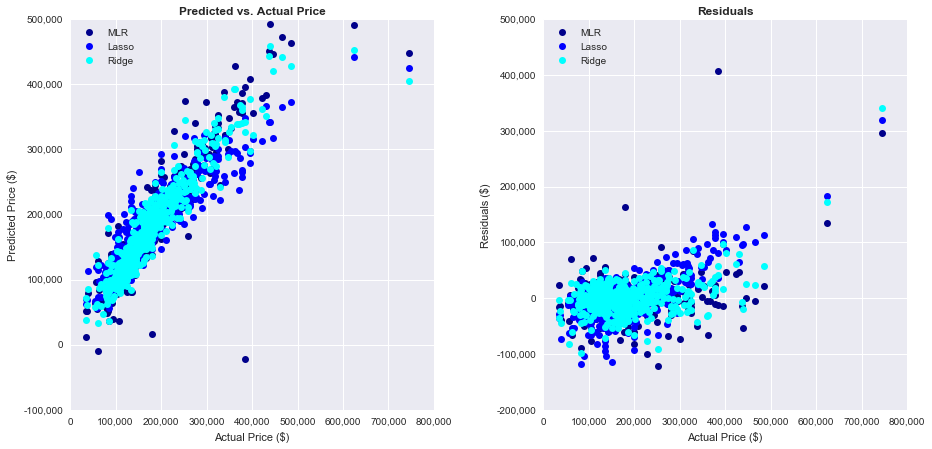

In [10]:
#Model residuals

MLRresiduals_reg = y_test - MLR_predict_reg
lassoResiduals_reg = y_test - lasso_predict_reg
ridgeResiduals_reg = y_test - ridge_predict_reg

# Plot residuals
fig = plt.figure(figsize=(15, 7))

# Predicted vs. Actual
ax1 = fig.add_subplot(121)
ax1.plot(y_test,MLR_predict_reg,"o",label='MLR', color='darkblue')
ax1.plot(y_test,lasso_predict_reg,"o",label='Lasso',color='blue')
ax1.plot(y_test,ridge_predict_reg,"o",label='Ridge',color='aqua')
ax1.legend(numpoints=1,loc='upper left')
ax1.set_ylabel('Predicted Price ($)')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_xlabel('Actual Price ($)')
ax1.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_title('Predicted vs. Actual Price', fontsize=12, fontweight='bold')

# Residuals
ax2 = fig.add_subplot(122)
ax2.plot(y_test,MLRresiduals_reg,"o",label='MLR',color='darkblue')
ax2.plot(y_test,lassoResiduals_reg,"o",label='Lasso',color='blue')
ax2.plot(y_test,ridgeResiduals_reg,"o",label='Ridge',color='aqua')
ax2.legend(numpoints=1,loc='upper left')
ax2.set_ylabel('Residuals ($)')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_xlabel('Actual Price ($)')
ax2.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_title('Residuals', fontsize=12, fontweight='bold')

fig.subplots_adjust(wspace=.3)
plt.show()

In [11]:
# Try predicting using log SalePrice
log_y_train = y_train.map(float).map(log)
log_y_test = y_test.map(float).map(log)

In [12]:
#Linear Regression
MLR =LinearRegression()
model_MLR_log = MLR.fit(X_train,log_y_train)
MLR_predict_log = model_MLR_log.predict(X_test)
MLR_RMSE_log = sqrt(mean_squared_error(y_test, np.exp(MLR_predict_log)))
print "MLR RMSE:",MLR_RMSE_log

#get best λ with LassoCV
lasso_cv_log = LassoCV(alphas=None, cv=10, max_iter=10000)
model_cv_log = lasso_cv_log.fit(X_train,ravel(log_y_train))
print "Lasso CV best λ:",model_cv_log.alpha_
lasso_predict_log= model_cv_log.predict(X_test)
lasso_RMSE_log = sqrt(mean_squared_error(y_test, np.exp(lasso_predict_log)))
print "Lasso RMSE:",lasso_RMSE_log

#get best λ with RidgeCV
ridge_cv_log = RidgeCV(cv=10)
ridge_model_cv_log = ridge_cv_log.fit(X_train,ravel(log_y_train))
print "Ridge CV best λ:",ridge_model_cv_log.alpha_
ridge_predict_log = ridge_model_cv_log.predict(X_test)
ridge_RMSE_log = sqrt(mean_squared_error(y_test, np.exp(ridge_predict_log)))
print "Ridge RMSE:",ridge_RMSE_log

MLR RMSE: 26496.3728966
Lasso CV best λ: 1.09577311917
Lasso RMSE: 35654.450704
Ridge CV best λ: 10.0
Ridge RMSE: 27192.1780365


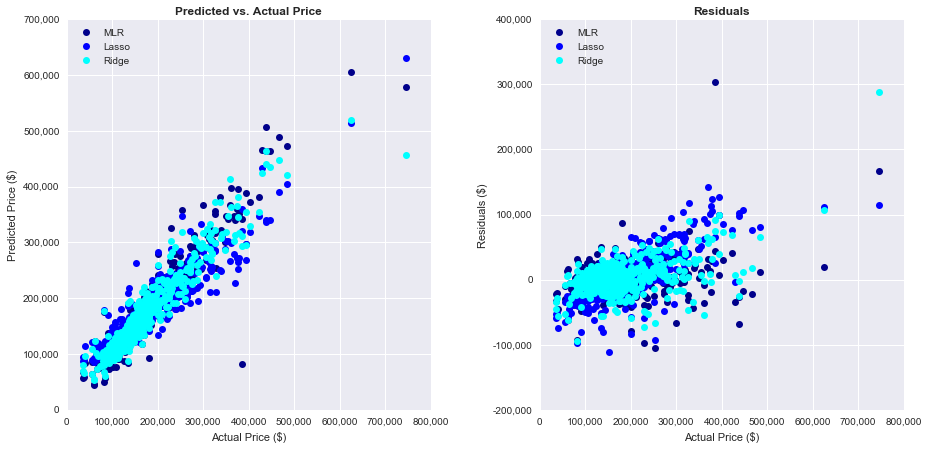

In [13]:
#residuals with log price models (in original scale)
MLRresiduals_log = y_test - np.exp(MLR_predict_log)
lassoResiduals_log = y_test - np.exp(lasso_predict_log)
ridgeResiduals_log = y_test - np.exp(ridge_predict_log)

# Plot residuals
fig = plt.figure(figsize=(15, 7))

# Predicted vs. Actual
ax1 = fig.add_subplot(121)
ax1.plot(y_test,np.exp(MLR_predict_log),"o",label='MLR',color='darkblue')
ax1.plot(y_test,np.exp(lasso_predict_log),"o",label='Lasso',color='blue')
ax1.plot(y_test,np.exp(ridge_predict_log),"o",label='Ridge',color='aqua')
ax1.legend(numpoints=1,loc='upper left')
ax1.set_ylabel('Predicted Price ($)')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_xlabel('Actual Price ($)')
ax1.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_title('Predicted vs. Actual Price', fontsize=12, fontweight='bold')

# Residuals
ax2 = fig.add_subplot(122)
ax2.plot(y_test,MLRresiduals_log,"o",label='MLR',color='darkblue')
ax2.plot(y_test,lassoResiduals_log,"o",label='Lasso',color='blue')
ax2.plot(y_test,ridgeResiduals_log,"o",label='Ridge',color='aqua')
ax2.legend(numpoints=1,loc='upper left')
ax2.set_ylabel('Residuals ($)')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_xlabel('Actual Price ($)')
ax2.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_title('Residuals', fontsize=12, fontweight='bold')

fig.subplots_adjust(wspace=.3)
plt.show()

In [14]:
# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_scaler = StandardScaler()
Y_train_scaled = ravel(y_scaler.fit_transform(y_train.reshape(-1, 1)))
Y_test_scaled = ravel(y_scaler.transform(y_test.reshape(-1, 1)))

C:\Users\Vishwa\Anaconda2\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [15]:
# Run MLP using different hidden layer sizes
sizes = [(20,),(50,),(100,),(150,),(200,),(250,),(300,)]
RMSEs = []
for size in sizes:
    MLP = MLPRegressor(hidden_layer_sizes = size,activation='tanh',solver='sgd',learning_rate='constant',random_state=42,\
                       batch_size=40,learning_rate_init=0.001)
    model_MLP = MLP.fit(X_train_scaled,Y_train_scaled)
    MLP_predict = model_MLP.predict(X_test_scaled)
    MLP_RMSE= sqrt(mean_squared_error(y_test, y_scaler.inverse_transform(MLP_predict)))
    RMSEs.append(MLP_RMSE)

In [16]:
# Choosing hidden layer size with best RMSE
MLP = MLPRegressor(hidden_layer_sizes = sizes[np.argmin(RMSEs)],activation='tanh',solver='sgd',learning_rate='constant',random_state=42,\
                   batch_size=40,learning_rate_init=0.001)
model_MLP = MLP.fit(X_train_scaled,Y_train_scaled)
MLP_predict_scale = model_MLP.predict(X_test_scaled)
MLP_RMSE_scale = sqrt(mean_squared_error(y_test, y_scaler.inverse_transform(MLP_predict_scale)))
print "MLP RMSE:",MLP_RMSE_scale

MLPresiduals_scale = y_test - y_scaler.inverse_transform(MLP_predict_scale)

MLP RMSE: 36772.0968904


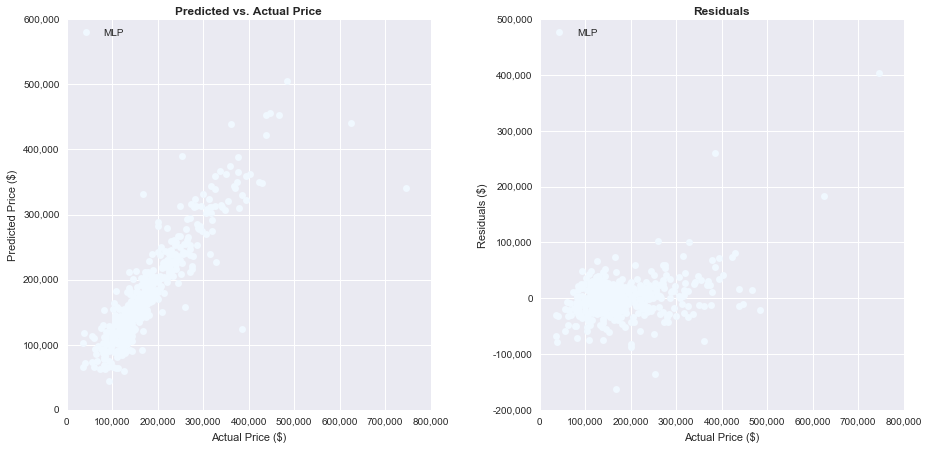

In [17]:
# Plot residuals
fig = plt.figure(figsize=(15, 7))

# Predicted vs. Actual
ax1 = fig.add_subplot(121)
ax1.plot(y_test,y_scaler.inverse_transform(MLP_predict_scale),"o",label='MLP',color='aliceblue')
ax1.legend(numpoints=1,loc='upper left')
ax1.set_ylabel('Predicted Price ($)')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_xlabel('Actual Price ($)')
ax1.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_title('Predicted vs. Actual Price', fontsize=12, fontweight='bold')

# Residuals
ax2 = fig.add_subplot(122)
ax2.plot(y_test,MLPresiduals_scale, "o",label='MLP',color='aliceblue')
ax2.legend(numpoints=1,loc='upper left')
ax2.set_ylabel('Residuals ($)')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_xlabel('Actual Price ($)')
ax2.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_title('Residuals', fontsize=12, fontweight='bold')

fig.subplots_adjust(wspace=.3)
plt.show()

In [18]:
# Try Linear Regression, Lasso, and Ridge with scaled X data

#Linear Regression
MLR =LinearRegression(fit_intercept=False)
model_MLR_scale = MLR.fit(X_train_scaled,y_train)
MLR_predict_scale = model_MLR_scale.predict(X_test_scaled)
MLR_RMSE_scale= sqrt(mean_squared_error(y_test, MLR_predict_scale))
print "MLR RMSE:",MLR_RMSE_scale

#get best λ with LassoCV
lasso_cv_scale = LassoCV(alphas=None, cv=10, max_iter=10000)
model_cv_scale = lasso_cv_scale.fit(X_train_scaled,ravel(y_train))
print "Lasso CV best λ:",model_cv_scale.alpha_
lasso_predict_scale = model_cv_scale.predict(X_test_scaled)
lasso_RMSE_scale= sqrt(mean_squared_error(y_test, lasso_predict_scale))
print "Lasso RMSE:",lasso_RMSE_scale

#get best λ with RidgeCV
ridge_cv_scale = RidgeCV(cv=10)
ridge_model_cv_scale = ridge_cv_scale.fit(X_train_scaled,ravel(y_train))
print "Ridge CV best λ:",ridge_model_cv_scale.alpha_
ridge_predict_scale= ridge_model_cv_scale.predict(X_test_scaled)
ridge_RMSE_scale= sqrt(mean_squared_error(y_test, ridge_predict_scale))
print "Ridge RMSE:",ridge_RMSE_scale

MLR RMSE: 1.69957930837e+17
Lasso CV best λ: 1695.52642749
Lasso RMSE: 29882.5642463
Ridge CV best λ: 10.0
Ridge RMSE: 34040.3447551


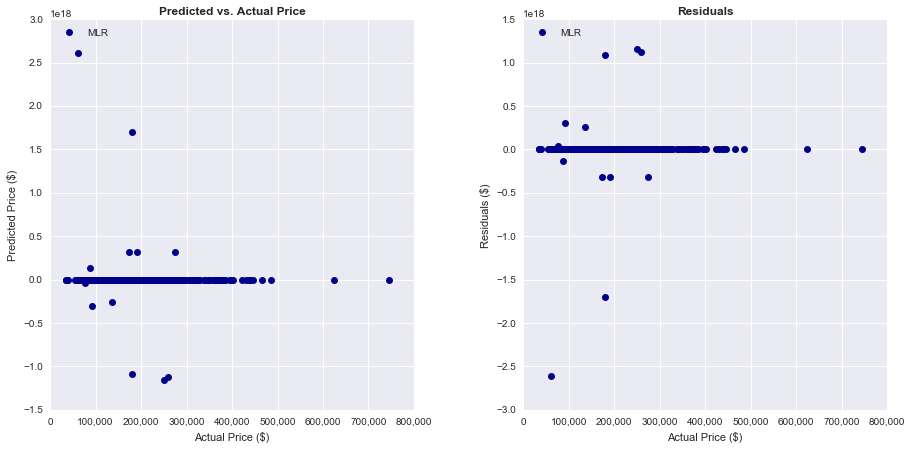

In [19]:
# Based on RMSE, it appears as though MLR may have challenges predicting this data
# For example, the linear regression problem could be under-determined 
#  (where the number of linearly independent rows of the training matrix 
#    is less than its number of linearly independent columns),
#  resulting in erroneous predictions

# Graph to see
MLRresiduals_scale = y_test - MLR_predict_scale
fig = plt.figure(figsize=(15, 7))

# Predicted vs. Actual
ax1 = fig.add_subplot(121)
ax1.plot(y_test,MLR_predict_scale,"o",label='MLR',color='darkblue')
ax1.legend(numpoints=1,loc='upper left')
ax1.set_ylabel('Predicted Price ($)')
ax1.set_xlabel('Actual Price ($)')
ax1.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_title('Predicted vs. Actual Price', fontsize=12, fontweight='bold')

# Residuals
ax2 = fig.add_subplot(122)
ax2.plot(y_test,MLRresiduals_scale, "o",label='MLR',color='darkblue')
ax2.legend(numpoints=1,loc='upper left')
ax2.set_ylabel('Residuals ($)')
ax2.set_xlabel('Actual Price ($)')
ax2.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_title('Residuals', fontsize=12, fontweight='bold')

fig.subplots_adjust(wspace=.3)
plt.show()

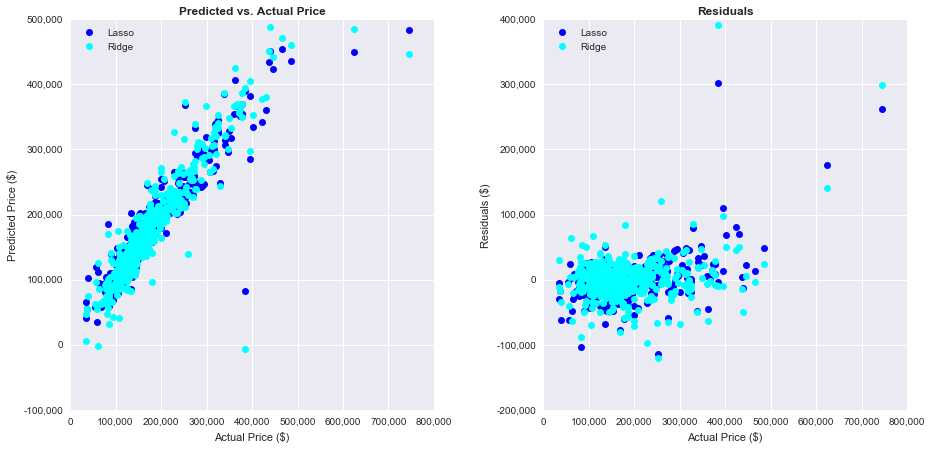

In [20]:
# Plot Lasso and Ridge
lassoResiduals_scale = y_test - lasso_predict_scale
ridgeResiduals_scale = y_test - ridge_predict_scale

fig = plt.figure(figsize=(15, 7))

# Predicted vs. Actual
ax1 = fig.add_subplot(121)
ax1.plot(y_test,lasso_predict_scale,"o",label='Lasso',color='blue')
ax1.plot(y_test,ridge_predict_scale,"o",label='Ridge',color='aqua')
ax1.legend(numpoints=1,loc='upper left')
ax1.set_ylabel('Predicted Price ($)')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_xlabel('Actual Price ($)')
ax1.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_title('Predicted vs. Actual Price', fontsize=12, fontweight='bold')

# Residuals
ax2 = fig.add_subplot(122)
ax2.plot(y_test,lassoResiduals_scale,"o",label='Lasso',color='blue')
ax2.plot(y_test,ridgeResiduals_scale,"o",label='Ridge',color='aqua')
ax2.legend(numpoints=1,loc='upper left')
ax2.set_ylabel('Residuals ($)')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_xlabel('Actual Price ($)')
ax2.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_title('Residuals', fontsize=12, fontweight='bold')

fig.subplots_adjust(wspace=.3)
plt.show()

In [21]:
# Try fitting on scaled data and log SalePrice for Lasso and Ridge
#get best λ with LassoCV
lasso_cv_scalelog = LassoCV(alphas=None, cv=10, max_iter=10000)
model_cv_scalelog = lasso_cv_scalelog.fit(X_train_scaled,ravel(log_y_train))
print "Lasso CV best λ:",model_cv_scalelog.alpha_
lasso_predict_scalelog= model_cv_scalelog.predict(X_test_scaled)
lasso_RMSE_scalelog = sqrt(mean_squared_error(y_test, np.exp(lasso_predict_scalelog)))
print "Lasso RMSE:",lasso_RMSE_scalelog

#get best λ with RidgeCV
ridge_cv_scalelog = RidgeCV(cv=10)
ridge_model_cv_scalelog = ridge_cv_scalelog.fit(X_train_scaled,ravel(log_y_train))
print "Ridge CV best λ:",ridge_model_cv_scalelog.alpha_
ridge_predict_scalelog= ridge_model_cv_scalelog.predict(X_test_scaled)
ridge_RMSE_scalelog = sqrt(mean_squared_error(y_test, np.exp(ridge_predict_scalelog)))
print "Ridge RMSE:",ridge_RMSE_scalelog

Lasso CV best λ: 0.00617476647261
Lasso RMSE: 23728.2472125
Ridge CV best λ: 10.0
Ridge RMSE: 26598.7289092


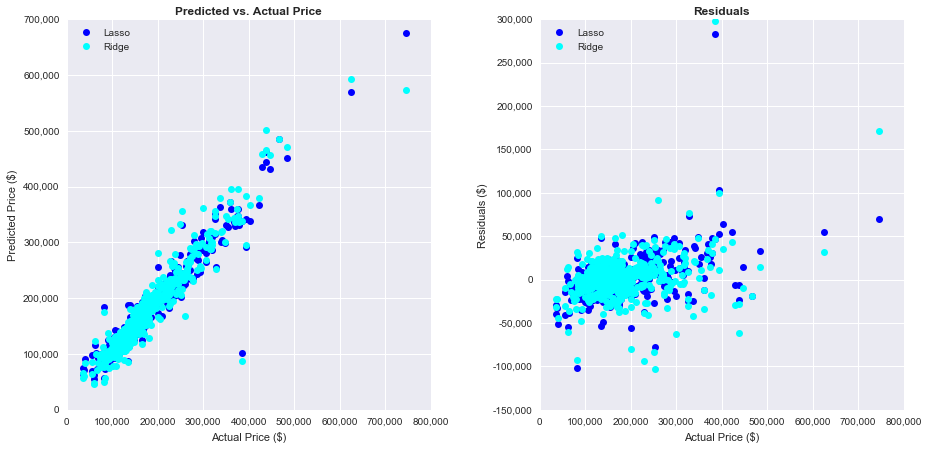

In [22]:
# Plot Lasso and Ridge results for scaled X data / log SalePrice
lassoResiduals_scalelog = y_test - np.exp(lasso_predict_scalelog)
ridgeResiduals_scalelog = y_test - np.exp(ridge_predict_scalelog)

fig = plt.figure(figsize=(15, 7))

# Predicted vs. Actual
ax1 = fig.add_subplot(121)
ax1.plot(y_test,np.exp(lasso_predict_scalelog),"o",label='Lasso',color='blue')
ax1.plot(y_test,np.exp(ridge_predict_scalelog),"o",label='Ridge',color='aqua')
ax1.legend(numpoints=1,loc='upper left')
ax1.set_ylabel('Predicted Price ($)')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_xlabel('Actual Price ($)')
ax1.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_title('Predicted vs. Actual Price', fontsize=12, fontweight='bold')

# Residuals
ax2 = fig.add_subplot(122)
ax2.plot(y_test,lassoResiduals_scalelog,"o",label='Lasso',color='blue')
ax2.plot(y_test,ridgeResiduals_scalelog,"o",label='Ridge',color='aqua')
ax2.legend(numpoints=1,loc='upper left')
ax2.set_ylabel('Residuals ($)')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_xlabel('Actual Price ($)')
ax2.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_title('Residuals', fontsize=12, fontweight='bold')

fig.subplots_adjust(wspace=.3)
plt.show()

### SVR

In [23]:
SVR_reg = SVR(kernel='linear', C=10)
SVR_reg.fit(X_train,y_train)
SVR_predict_reg=SVR_reg.predict(X_test)
SVR_RMSE_reg=np.sqrt(mean_squared_error(y_test,SVR_predict_reg))
SVR_RMSE_reg

34771.304296554568

In [24]:
SVR_scale = SVR(kernel='linear', C=10)
SVR_scale.fit(X_train_scaled,y_train)
SVR_predict_scale=SVR_scale.predict(X_test_scaled)
SVR_RMSE_scale=np.sqrt(mean_squared_error(y_test,SVR_predict_scale))
SVR_RMSE_scale

42936.024596161988

In [ ]:
SVR_log = SVR(kernel='linear', C=10)
SVR_log.fit(X_train,ravel(log_y_train))
SVR_predict_log=SVR_log.predict(X_test)
SVR_RMSE_log=np.sqrt(mean_squared_error(y_test,np.exp(SVR_predict_log)))
SVR_RMSE_log

In [25]:
SVR_scalelog = SVR(kernel='linear', C=10)
SVR_scalelog.fit(X_train_scaled,ravel(log_y_train))
SVR_predict_scalelog=SVR_scalelog.predict(X_test_scaled)
SVR_RMSE_scalelog=np.sqrt(mean_squared_error(y_test,np.exp(SVR_predict_scalelog)))
SVR_RMSE_scalelog

27537.162125152379

### SGD Regressor

In [26]:
parameters = {'loss': ['squared_loss', 'huber'],
             'penalty': ['l1','l2'],
              'learning_rate': ['optimal','invscaling','constant']}
accuracy=make_scorer(mean_squared_error, greater_is_better=False)
SGDclf_reg = GridSearchCV(SGDRegressor(random_state=42), parameters, cv=5,scoring=accuracy)
SGDclf_reg.fit(X_train, y_train) 

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=42, shuffle=True, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'loss': ['squared_loss', 'huber'], 'learning_rate': ['optimal', 'invscaling', 'constant']},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(mean_squared_error, greater_is_better=False),
       verbose=0)

In [27]:
print SGDclf_reg.best_params_
print SGDclf_reg.best_score_

{'penalty': 'l1', 'loss': 'huber', 'learning_rate': 'invscaling'}
-2781382792.37


In [28]:
GSCV_SGDclf_reg = SGDRegressor(loss='huber', penalty='l2', alpha=0.001, random_state=42)
GSCV_SGDclf_reg.fit(X_train, y_train)
GSCV_SGDclf_predict_reg = GSCV_SGDclf_reg.predict(X_test)
GSCV_SGDclf_RMSE_reg=np.sqrt(mean_squared_error(y_test, GSCV_SGDclf_predict_reg))
GSCV_SGDclf_RMSE_reg

43019.412174944628

In [29]:
parameters = {'loss': ['squared_loss', 'huber'],
             'penalty': ['l1','l2'],
              'alpha': [0.01, 0.001, 0.0001]
             }
accuracy=make_scorer(mean_squared_error, greater_is_better=False)
SGDclf_scale = GridSearchCV(SGDRegressor(random_state=42), parameters, cv=5,scoring=accuracy)
SGDclf_scale.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=42, shuffle=True, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'loss': ['squared_loss', 'huber'], 'alpha': [0.01, 0.001, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(mean_squared_error, greater_is_better=False),
       verbose=0)

In [30]:
print SGDclf_scale.best_params_
print SGDclf_scale.best_score_

{'penalty': 'l1', 'alpha': 0.01, 'loss': 'huber'}
-38717053033.4


In [31]:
GSCV_SGDclf_scale = SGDRegressor(penalty='l1', alpha=0.01, loss='huber', random_state=42)
GSCV_SGDclf_scale.fit(X_train_scaled, y_train)
GSCV_SGDclf_predict_scale = GSCV_SGDclf_scale.predict(X_test_scaled)
GSCV_SGDclf_RMSE_scale=np.sqrt(mean_squared_error(y_test, GSCV_SGDclf_predict_scale))
GSCV_SGDclf_RMSE_scale

199229.24122874188

In [32]:
parameters = {'loss': ['squared_loss', 'huber'],
             'penalty': ['l1','l2'],
              'alpha': [0.01, 0.001, 0.0001]
             }
accuracy=make_scorer(mean_squared_error, greater_is_better=False)
SGDclf_log = GridSearchCV(SGDRegressor(random_state=42), parameters, cv=5,scoring=accuracy)
SGDclf_log.fit(X_train, log_y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=42, shuffle=True, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'loss': ['squared_loss', 'huber'], 'alpha': [0.01, 0.001, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(mean_squared_error, greater_is_better=False),
       verbose=0)

In [33]:
print SGDclf_log.best_params_
print SGDclf_log.best_score_

{'penalty': 'l1', 'alpha': 0.0001, 'loss': 'huber'}
-79845792.4558


In [ ]:
### NOT SURE OF BEST PARAMS -- LOG WOULDN'T RUN
# GSCV_SGDclf_log = SGDRegressor(penalty='l1', alpha=0.01, loss='huber', random_state=42)
# GSCV_SGDclf_log.fit(X_train, log_y_train)
# GSCV_SGDclf_predict_log = GSCV_SGDclf_log.predict(X_test)
# GSCV_SGDclf_RMSE_log=np.sqrt(mean_squared_error(y_test, np.exp(GSCV_SGDclf_predict_log)))
# GSCV_SGDclf_RMSE_log

In [34]:
parameters = {'loss': ['squared_loss', 'huber'],
             'penalty': ['l1','l2'],
              'alpha': [0.01, 0.001, 0.0001]
             }
accuracy=make_scorer(mean_squared_error, greater_is_better=False)
SGDclf_scalelog = GridSearchCV(SGDRegressor(random_state=42), parameters, cv=5,scoring=accuracy)
SGDclf_scalelog.fit(X_train_scaled, log_y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=42, shuffle=True, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'loss': ['squared_loss', 'huber'], 'alpha': [0.01, 0.001, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(mean_squared_error, greater_is_better=False),
       verbose=0)

In [35]:
print SGDclf_scalelog.best_params_
print SGDclf_scalelog.best_score_

{'penalty': 'l1', 'alpha': 0.01, 'loss': 'huber'}
-129.479191791


In [ ]:
### NOT SURE OF BEST PARAMS -- LOG WOULDN'T RUN
# GSCV_SGDclf_scalelog = SGDRegressor(penalty='l1', alpha=0.01, loss='huber', random_state=42)
# GSCV_SGDclf_scalelog.fit(X_train_scaled, log_y_train)
# GSCV_SGDclf_predict_scalelog = GSCV_SGDclf_scalelog.predict(X_test_scaled)
# GSCV_SGDclf_RMSE_scalelog=np.sqrt(mean_squared_error(y_test, np.exp(GSCV_SGDclf_predict_scalelog)))
# GSCV_SGDclf_RMSE_scalelog

### Regression Trees

In [36]:
# Create and fit the model
model_tree2_reg = DecisionTreeRegressor(random_state = 1)
model_tree2_reg.fit(X_train, y_train)

# Predict on the test set
p_tree2_reg = model_tree2_reg.predict(X_test)

# Calculate RMSE of the model
REGTREE_residuals_reg = p_tree2_reg - y_test
REGTREE_MSE_reg = (REGTREE_residuals_reg**2).mean()
REGTREE_RMSE_reg = math.sqrt(REGTREE_MSE_reg)

print "RMSE for Regression Tree is:", round(REGTREE_RMSE_reg,4)

RMSE for Regression Tree is: 36761.5502


In [37]:
# Create and fit the model
model_tree2_log = DecisionTreeRegressor(random_state = 1)
model_tree2_log.fit(X_train, log_y_train)

# Predict on the test set
p_tree2_log = model_tree2_log.predict(X_test)

# Calculate RMSE of the model
REGTREE_residuals_log = np.exp(p_tree2_log) - y_test
REGTREE_MSE_log = (REGTREE_residuals_log**2).mean()
REGTREE_RMSE_log = math.sqrt(REGTREE_MSE_log)

print "RMSE for Regression Tree USING LOG is:", round(REGTREE_RMSE_log,4)

RMSE for Regression Tree USING LOG is: 47427.6437


In [38]:
# Create and fit the model
model_tree2_scale = DecisionTreeRegressor(random_state = 1)
model_tree2_scale.fit(X_train_scaled, y_train)

# Predict on the test set
p_tree2_scale = model_tree2_scale.predict(X_test_scaled)

# Calculate RMSE of the model
REGTREE_residuals_scale = p_tree2_scale - y_test
REGTREE_MSE_scale = (REGTREE_residuals_scale**2).mean()
REGTREE_RMSE_scale = math.sqrt(REGTREE_MSE_scale)

print "RMSE with scaling Regression Tree is:", round(REGTREE_RMSE_scale,4)

RMSE with scaling Regression Tree is: 36761.5502


In [39]:
# Create and fit the model
model_tree2_scalelog = DecisionTreeRegressor(random_state = 1)
model_tree2_scalelog.fit(X_train_scaled, log_y_train)

# Predict on the test set
p_tree2_scalelog = model_tree2_scalelog.predict(X_test_scaled)

# Calculate RMSE of the model
REGTREE_residuals_scalelog = np.exp(p_tree2_scalelog) - y_test
REGTREE_MSE_scalelog = (REGTREE_residuals_scalelog**2).mean()
REGTREE_RMSE_scalelog = math.sqrt(REGTREE_MSE_scalelog)

print "RMSE with scaling for Regression Tree USING LOG is:", round(REGTREE_RMSE_scalelog,4)

RMSE with scaling for Regression Tree USING LOG is: 47425.9335


In [40]:
# # Feature importances from Model 1
# imp_tree1 = pd.Series(model_tree1.feature_importances_,X_train.columns.values)
# print imp_tree1.sort_values(ascending = False)[:10]

# Feature importances from Model 2
imp_tree2 = pd.Series(model_tree2_reg.feature_importances_,X_train.columns.values)
print imp_tree2.sort_values(ascending = False)[:10]

OverallQual        0.614600
GrLivArea          0.086107
BsmtFinSF1         0.046798
2ndFlrSF           0.030195
TotalBsmtSF        0.029737
GarageArea         0.018786
LotArea            0.018527
BsmtExposure_Gd    0.017897
LotFrontage        0.017661
WoodDeckSF         0.014118
dtype: float64


In [41]:
# SUMMARY - Regression Trees
print "RMSE for Regression Tree is:", round(REGTREE_RMSE_reg,4)
print "RMSE for Regression Tree USING LOG is:", round(REGTREE_RMSE_log,4)
print "RMSE with scaling Regression Tree is:", round(REGTREE_RMSE_scale,4)
print "RMSE with scaling for Regression Tree USING LOG is:", round(REGTREE_RMSE_scalelog,4)

RMSE for Regression Tree is: 36761.5502
RMSE for Regression Tree USING LOG is: 47427.6437
RMSE with scaling Regression Tree is: 36761.5502
RMSE with scaling for Regression Tree USING LOG is: 47425.9335


###  Random Forest (GridSearchCV)

In [42]:
# Cross validate RF model
# Set parameter dictionary to search through
params = {'n_estimators':[10,100,500, 1000], 'max_depth':[5,10,20]}

# Create model and fit best parameters
model_rf2 = RandomForestRegressor()
model_rf2_GS_reg = GridSearchCV(model_rf2, params)
model_rf2_GS_log = GridSearchCV(model_rf2, params)
model_rf2_GS_scale = GridSearchCV(model_rf2, params)
model_rf2_GS_scalelog = GridSearchCV(model_rf2, params)

In [43]:
# Avoid running, build a RF model below
model_rf2_GS_reg.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 100, 500, 1000], 'max_depth': [5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [44]:
# Avoid running, build a RF model below
model_rf2_GS_log.fit(X_train, log_y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 100, 500, 1000], 'max_depth': [5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [45]:
# Avoid running, build a RF model below
model_rf2_GS_scale.fit(X_train_scaled, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 100, 500, 1000], 'max_depth': [5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [46]:
# Avoid running, build a RF model below
model_rf2_GS_scalelog.fit(X_train_scaled, log_y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 100, 500, 1000], 'max_depth': [5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [47]:
# Save best estimates to avoid re-running grid search
model_rf2_GS_reg_best=model_rf2_GS_reg.best_estimator_
model_rf2_GS_log_best=model_rf2_GS_log.best_estimator_
model_rf2_GS_scale_best=model_rf2_GS_scale.best_estimator_
model_rf2_GS_scalelog_best=model_rf2_GS_scalelog.best_estimator_

In [48]:
# Make predictions on Grid search optimized RF model
p_rf2_reg = model_rf2_GS_reg.predict(X_test)

# Calculate RMSE of the model
GS_RANDFOR_residuals_reg = p_rf2_reg - y_test
GS_RANDFOR_MSE_reg = (GS_RANDFOR_residuals_reg**2).mean()
GS_RANDFOR_RMSE_reg = math.sqrt(GS_RANDFOR_MSE_reg)

print "RMSE for GS Random Forest is:", round(GS_RANDFOR_RMSE_reg,4)

RMSE for GS Random Forest is: 25990.9402


In [49]:
# Make predictions on Grid search optimized RF model
p_rf2_log = model_rf2_GS_log.predict(X_test)

# Calculate RMSE of the model
GS_RANDFOR_residuals_log = np.exp(p_rf2_log) - y_test
GS_RANDFOR_MSE_log = (GS_RANDFOR_residuals_log**2).mean()
GS_RANDFOR_RMSE_log = math.sqrt(GS_RANDFOR_MSE_log)

print "RMSE for GS Random Forest USING LOG is:", round(GS_RANDFOR_RMSE_log,4)

RMSE for GS Random Forest USING LOG is: 28373.1619


In [50]:
# Make predictions on Grid search optimized RF model
p_rf2_scale = model_rf2_GS_scale.predict(X_test_scaled)

# Calculate RMSE of the model
GS_RANDFOR_residuals_scale = p_rf2_scale - y_test
GS_RANDFOR_MSE_scale = (GS_RANDFOR_residuals_scale**2).mean()
GS_RANDFOR_RMSE_scale = math.sqrt(GS_RANDFOR_MSE_scale)

print "RMSE using scaling for GS Random Forest is:", round(GS_RANDFOR_RMSE_scale,4)

RMSE using scaling for GS Random Forest is: 25461.5528


In [51]:
# Make predictions on Grid search optimized RF model
p_rf2_scalelog = model_rf2_GS_scalelog.predict(X_test_scaled)

# Calculate RMSE of the model
GS_RANDFOR_residuals_scalelog = np.exp(p_rf2_scalelog) - y_test
GS_RANDFOR_MSE_scalelog = (GS_RANDFOR_residuals_scalelog**2).mean()
GS_RANDFOR_RMSE_scalelog = math.sqrt(GS_RANDFOR_MSE_scalelog)

print "RMSE using scaling for GS Random Forest USING LOG is:", round(GS_RANDFOR_RMSE_scalelog,4)

RMSE using scaling for GS Random Forest USING LOG is: 28693.662


In [52]:
# SUMMARY - GridsearchCV on Random Forests
print "RMSE for GS Random Forest is:", round(GS_RANDFOR_RMSE_reg,4)
print "RMSE for GS Random Forest USING LOG is:", round(GS_RANDFOR_RMSE_log,4)
print "RMSE using scaling for GS Random Forest is:", round(GS_RANDFOR_RMSE_scale,4)
print "RMSE using scaling for GS Random Forest USING LOG is:", round(GS_RANDFOR_RMSE_scalelog,4)

RMSE for GS Random Forest is: 25990.9402
RMSE for GS Random Forest USING LOG is: 28373.1619
RMSE using scaling for GS Random Forest is: 25461.5528
RMSE using scaling for GS Random Forest USING LOG is: 28693.662


### Gradient Boosting (GridSearchCV)

In [53]:
# Create Gradient Boosting Model
model_gb1 = GradientBoostingRegressor()

# Create parameter dictionary for GridSearchCV
params = {'n_estimators':(5,10,50,100,500,1000),'learning_rate':(0.01, 0.05, 0.1, 0.2)}

#Create Grid Search Model
model_gb1_GS = GridSearchCV(model_gb1,params)
model_gb1_GS_reg = GridSearchCV(model_gb1, params)
model_gb1_GS_log = GridSearchCV(model_gb1, params)
model_gb1_GS_scale = GridSearchCV(model_gb1, params)
model_gb1_GS_scalelog = GridSearchCV(model_gb1, params)

In [54]:
# Avoid running, build a RF model below
model_gb1_GS_reg.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': (5, 10, 50, 100, 500, 1000), 'learning_rate': (0.01, 0.05, 0.1, 0.2)},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [55]:
# Avoid running, build a RF model below
model_gb1_GS_log.fit(X_train, log_y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': (5, 10, 50, 100, 500, 1000), 'learning_rate': (0.01, 0.05, 0.1, 0.2)},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [56]:
# Avoid running, build a RF model below
model_gb1_GS_scale.fit(X_train_scaled, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': (5, 10, 50, 100, 500, 1000), 'learning_rate': (0.01, 0.05, 0.1, 0.2)},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [57]:
# Avoid running, build a RF model below
model_gb1_GS_scalelog.fit(X_train_scaled, log_y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': (5, 10, 50, 100, 500, 1000), 'learning_rate': (0.01, 0.05, 0.1, 0.2)},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [58]:
# Save best estimates to avoid re-running grid search
model_gb1_GS_reg_best=model_gb1_GS_reg.best_estimator_
model_gb1_GS_log_best=model_gb1_GS_log.best_estimator_
model_gb1_GS_scale_best=model_gb1_GS_scale.best_estimator_
model_gb1_GS_scalelog_best=model_gb1_GS_scalelog.best_estimator_

In [59]:
# Make predictions on Grid search optimized Gradient Boosting model
p_gb1_reg = model_gb1_GS_reg.predict(X_test)

# Calculate RMSE of the model
GS_GRADBOOST_residuals_reg = p_gb1_reg - y_test
GS_GRADBOOST_MSE_reg = (GS_GRADBOOST_residuals_reg**2).mean()
GS_GRADBOOST_RMSE_reg = math.sqrt(GS_GRADBOOST_MSE_reg)

print "RMSE for GS Gradient Boosting is:", round(GS_GRADBOOST_RMSE_reg,4)

RMSE for GS Gradient Boosting is: 22124.5529


In [60]:
# Make predictions on Grid search optimized Gradient Boosting model
p_gb1_log = model_gb1_GS_log.predict(X_test)

# Calculate RMSE of the model
GS_GRADBOOST_residuals_log = np.exp(p_gb1_log) - y_test
GS_GRADBOOST_MSE_log = (GS_GRADBOOST_residuals_log**2).mean()
GS_GRADBOOST_RMSE_log = math.sqrt(GS_GRADBOOST_MSE_log)

print "RMSE for GS Gradient Boosting USING LOG is:", round(GS_GRADBOOST_RMSE_log,4)

RMSE for GS Gradient Boosting USING LOG is: 23276.1445


In [61]:
# Make predictions on Grid search optimized Gradient Boosting model
p_gb1_scale = model_gb1_GS_scale.predict(X_test_scaled)

# Calculate RMSE of the model
GS_GRADBOOST_residuals_scale = p_gb1_scale - y_test
GS_GRADBOOST_MSE_scale = (GS_GRADBOOST_residuals_scale**2).mean()
GS_GRADBOOST_RMSE_scale = math.sqrt(GS_GRADBOOST_MSE_scale)

print "RMSE with scaling for GS Gradient Boosting is:", round(GS_GRADBOOST_RMSE_scale,4)

RMSE with scaling for GS Gradient Boosting is: 23001.7049


In [62]:
# Make predictions on Grid search optimized Gradient Boosting model
p_gb1_scalelog = model_gb1_GS_scalelog.predict(X_test_scaled)

# Calculate RMSE of the model
GS_GRADBOOST_residuals_scalelog = np.exp(p_gb1_scalelog) - y_test
GS_GRADBOOST_MSE_scalelog = (GS_GRADBOOST_residuals_scalelog**2).mean()
GS_GRADBOOST_RMSE_scalelog = math.sqrt(GS_GRADBOOST_MSE_scalelog)

print "RMSE with scaling for GS Gradient Boosting USING LOG is:", round(GS_GRADBOOST_RMSE_scalelog,4)

RMSE with scaling for GS Gradient Boosting USING LOG is: 22866.3013


In [63]:
# SUMMARY - GridsearchCV on Gradient Boosting
print "RMSE for GS Gradient Boosting is:", round(GS_GRADBOOST_RMSE_reg,4)
print "RMSE for GS Gradient Boosting USING LOG is:", round(GS_GRADBOOST_RMSE_log,4)
print "RMSE with scaling for GS Gradient Boosting is:", round(GS_GRADBOOST_RMSE_scale,4)
print "RMSE with scaling for GS Gradient Boosting USING LOG is:", round(GS_GRADBOOST_RMSE_scalelog,4)

RMSE for GS Gradient Boosting is: 22124.5529
RMSE for GS Gradient Boosting USING LOG is: 23276.1445
RMSE with scaling for GS Gradient Boosting is: 23001.7049
RMSE with scaling for GS Gradient Boosting USING LOG is: 22866.3013


### AdaBoost

In [64]:
#predictions are on average 1.17 times as large as the actual value
parameters={'learning_rate': [0.01, 0.001, 0.0001], 'loss': ['linear', 'square']}
accuracy=make_scorer(mean_squared_error, greater_is_better=False)
GS_ADABOOST = GridSearchCV(AdaBoostRegressor(random_state=0), parameters, cv=5,scoring=accuracy)
GS_ADABOOST.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'loss': ['linear', 'square'], 'learning_rate': [0.01, 0.001, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(mean_squared_error, greater_is_better=False),
       verbose=0)

In [65]:
GS_ADABOOST.best_params_

{'learning_rate': 0.01, 'loss': 'square'}

In [66]:
GS_ADABOOST_reg=AdaBoostRegressor(random_state=1, loss='linear', learning_rate=0.01)
GS_ADABOOST_reg.fit(X_train, y_train)
GS_ADABOOST_predict_reg=GS_ADABOOST_reg.predict(X_test)
GS_ADABOOST_RMSE_reg=np.sqrt(np.mean((y_test-GS_ADABOOST_predict_reg)**2))
GS_ADABOOST_RMSE_reg

39686.078018620377

In [67]:
GS_ADABOOST_scale=AdaBoostRegressor(random_state=1, loss='linear', learning_rate=0.01)
GS_ADABOOST_scale.fit(X_train_scaled, y_train)
GS_ADABOOST_predict_scale = GS_ADABOOST_scale.predict(X_test_scaled)
GS_ADABOOST_RMSE_scale=np.sqrt(np.mean((y_test-GS_ADABOOST_predict_scale)**2))
GS_ADABOOST_RMSE_scale

39148.283036708475

In [68]:
GS_ADABOOST_log=AdaBoostRegressor(random_state=1, loss='linear', learning_rate=0.01)
GS_ADABOOST_log.fit(X_train, log_y_train)
GS_ADABOOST_predict_log = GS_ADABOOST_log.predict(X_test)
GS_ADABOOST_RMSE_log=np.sqrt(np.mean((y_test-np.exp(GS_ADABOOST_predict_log))**2))
GS_ADABOOST_RMSE_log

42190.295730148951

In [69]:
GS_ADABOOST_scalelog=AdaBoostRegressor(random_state=1, loss='linear', learning_rate=0.01)
GS_ADABOOST_scalelog.fit(X_train_scaled, log_y_train)
GS_ADABOOST_predict_scalelog = GS_ADABOOST_scalelog.predict(X_test_scaled)
GS_ADABOOST_RMSE_scalelog=np.sqrt(np.mean((y_test-np.exp(GS_ADABOOST_predict_scalelog))**2))
GS_ADABOOST_RMSE_scalelog

41969.687380833719

### MARS

In [70]:
# Best Model
MARS_scalelog = Earth(max_degree= 3,penalty=2.0,feature_importance_type = "rss",
                      smooth=True,enable_pruning=True)

MARS_scalelog_fit = MARS_scalelog.fit(X_train_scaled,log_y_train)

In [71]:
# Model Summary
print MARS_scalelog_fit.summary()
print MARS_scalelog_fit.summary_feature_importances(sort_by = 'rss')

Earth Model
---------------------------------------------------------------------------------------------------
Basis Function                                                                Pruned  Coefficient  
---------------------------------------------------------------------------------------------------
(Intercept)                                                                   No      12.6109      
x2                                                                            No      0.082382     
C(x12|s=+1,0.114121,2.46204,5.11121)                                          No      0.0862657    
C(x12|s=-1,0.114121,2.46204,5.11121)                                          No      -0.130453    
C(x5|s=+1,0.616204,2.19736,6.72856)                                           No      0.0774731    
C(x5|s=-1,0.616204,2.19736,6.72856)                                           Yes     None         
x21*C(x5|s=-1,0.616204,2.19736,6.72856)                                       No      0.

In [72]:
MARS_predict_scalelog = MARS_scalelog_fit.predict(X_test_scaled)

MARS_RMSE_scalelog = np.sqrt(mean_squared_error(y_test,np.exp(MARS_predict_scalelog)))
print "The rmse for MARS is", MARS_RMSE_scalelog

The rmse for MARS is 27954.1886399


## MODEL COMPARISONS

In [73]:
models=['MLR','lasso','ridge','MLP','SVR','GSCV_SGDclf','MARS','REGTREE',
        'GS_ADABOOST','GS_GRADBOOST','GS_RANDFOR']
modelnames=['MLR','Lasso','Ridge','MLP','SVR','SGD Regression','MARS','Regression Tree',
            'Ada Boosting','Gradient Boost','Random Forest']
versions=['reg','log','scale','scalelog']
versionnames=['All Predictors','Log Price','Scaled Predictors','Scaled Predictors+LogPrice']
RMSEsummary_dict={}

for model in models:
    for version in versions:
        try:
            RMSE=eval(model+'_RMSE_'+version)
        except:
            RMSE='--'
        if version in RMSEsummary_dict.keys():
            RMSEsummary_dict[version].append(RMSE)
        else:
            RMSEsummary_dict[version]=[RMSE]


RMSEsummary=pd.DataFrame(RMSEsummary_dict,index=modelnames)
RMSEsummary=RMSEsummary.rename(columns=dict(zip(versions,versionnames)))
RMSEsummary=RMSEsummary[versionnames]
RMSEsummary

,All Predictors,Log Price,Scaled Predictors,Scaled Predictors+LogPrice
MLR,35116.7,26496.4,1.69958e+17,--
Lasso,39996,35654.5,29882.6,23728.2
Ridge,29828.1,27192.2,34040.3,26598.7
MLP,--,--,36772.1,--
SVR,34771.3,--,42936,27537.2
SGD Regression,43019.4,--,199229,--
MARS,--,--,--,27954.2
Regression Tree,36761.6,47427.6,36761.6,47425.9
Ada Boosting,39686.1,42190.3,39148.3,41969.7
Gradient Boost,22124.6,23276.1,23001.7,22866.3


In [74]:
# Best Residuals
BMresiduals_GRADBOOST_scale=GS_GRADBOOST_residuals_scale
BMresiduals_MARS_scalelog=y_test-np.exp(MARS_predict_scalelog)
BMresiduals_LASSO_scalelog=lassoResiduals_scalelog

# Worst Residuals
WMresiduals_SVR_scale=y_test-SVR_predict_scale
WMresiduals_ADABOOST_log=y_test-np.exp(GS_ADABOOST_predict_log)
WMresiduals_SGD_reg=y_test-GSCV_SGDclf_predict_reg

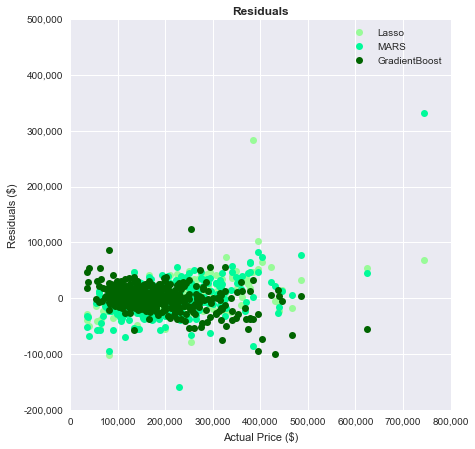

In [75]:
# Plot Residuals - Best Models
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121)
ax1.plot(y_test,BMresiduals_LASSO_scalelog,"o",label='Lasso',color='palegreen')
ax1.plot(y_test,BMresiduals_MARS_scalelog,"o",label='MARS',color='mediumspringgreen')
ax1.plot(y_test,BMresiduals_GRADBOOST_scale,"o",label='GradientBoost', color='darkgreen')
ax1.legend(numpoints=1,loc='upper right')
ax1.set_ylabel('Residuals ($)')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_ylim([-200000,500000])
ax1.set_xlabel('Actual Price ($)')
ax1.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_title('Residuals', fontsize=12, fontweight='bold')

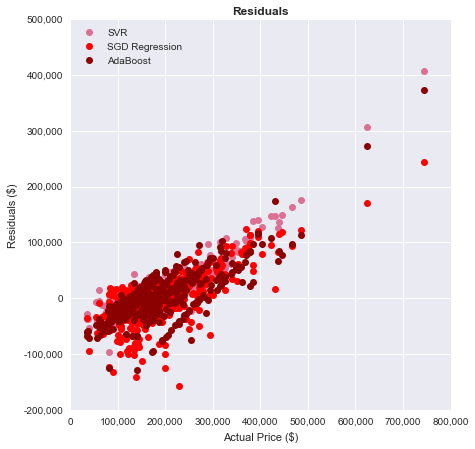

In [76]:
# Plot Residuals - Worst Models
fig = plt.figure(figsize=(15, 7))
ax2 = fig.add_subplot(121)
ax2.plot(y_test,WMresiduals_SVR_scale,"o",label='SVR',color='palevioletred')
ax2.plot(y_test,WMresiduals_SGD_reg,"o",label='SGD Regression',color='red')
ax2.plot(y_test,WMresiduals_ADABOOST_log,"o",label='AdaBoost', color='darkred')
ax2.legend(numpoints=1,loc='upper left')
ax2.set_ylabel('Residuals ($)')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_xlabel('Actual Price ($)')
ax2.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_title('Residuals', fontsize=12, fontweight='bold')

# Cross-validating Best Models and Creating Kaggle Submissions

In [87]:
X_comp['BsmtFinSF1'] = X_comp['BsmtFinSF1'].fillna(0.0)
X_comp['BsmtFinSF2'] = X_comp['BsmtFinSF2'].fillna(0.0)
X_comp['BsmtUnfSF'] = X_comp['BsmtUnfSF'].fillna(0.0)
X_comp['TotalBsmtSF'] = X_comp['TotalBsmtSF'].fillna(0.0)
X_comp['BsmtFullBath'] = X_comp['BsmtFullBath'].fillna(0.0)
X_comp['BsmtHalfBath'] = X_comp['BsmtHalfBath'].fillna(0.0)
X_comp['GarageCars'] = X_comp['GarageCars'].fillna(2.0)
X_comp['GarageArea'] = X_comp['GarageArea'].fillna(mean(X_test['GarageArea']))

In [88]:
# Transforming entire train set
log_y = y.map(float).map(log)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_comp_scaled = scaler.transform(X_comp)

In [89]:
lasso_cv_scalelog = LassoCV(alphas=None, cv=15, max_iter=10000).fit(X_scaled,ravel(log_y))
lasso_cv_scalelog.alpha_

0.0075382774064728809

In [92]:
#K-Fold validation for Lasso (scale_log)

kf = KFold(n_splits=5)

scores=[]
for train_index, test_index in kf.split(X_scaled):
    X_tr, X_ts = X_scaled[train_index], X_scaled[test_index]
    y_tr, y_ts = log_y[train_index], log_y[test_index]
    lasso = Lasso(alpha=lasso_cv_scalelog.alpha_)
    model=lasso.fit(X_tr,ravel(y_tr))
    predict=model.predict(X_ts)
    rmse = sqrt(mean_squared_error(np.exp(y_ts), np.exp(predict)))
    scores.append(rmse)
    
print scores
print mean(scores)

[19571.111196428177, 48314.678153804169, 28729.989499060157, 20278.236422664657, 126165.06722511743]
48611.8164994


In [93]:
ridge_cv_scalelog = RidgeCV(cv=15).fit(X_scaled,ravel(log_y))
ridge_model_cv_scalelog.alpha_


10.0

In [94]:
#K-Fold validation for Ridge (scale_log)

kf = KFold(n_splits=5)

scores=[]
for train_index, test_index in kf.split(X_scaled):
    X_tr, X_ts = X_scaled[train_index], X_scaled[test_index]
    y_tr, y_ts = log_y[train_index], log_y[test_index]
    Ridge = Ridge(alpha=ridge_model_cv_scalelog.alpha_)
    model=Ridge.fit(X_tr,ravel(y_tr))
    predict=model.predict(X_ts)
    rmse = sqrt(mean_squared_error(np.exp(y_ts), np.exp(predict)))
    scores.append(rmse)
    
print scores
print mean(scores)

[22416.255990609567, 46010.213053161024, 29828.79892032775, 18968.611386976438, 112675.85021089589]
45979.9459124


In [108]:
RidgeKagglePred = list(np.exp(ridge_cv_scalelog.predict(X_comp_scaled)))

# Save predictions to file
outfile = open('RidgeKagglePred.csv', 'w')
for item in RidgeKagglePred:
    outfile.write("%s\n" % item)
outfile.close()

In [95]:
# Create parameter dictionary for GridSearchCV
params = {'n_estimators':(5,10,50,100,500,1000),'learning_rate':(0.01, 0.05, 0.1, 0.2),'min_samples_leaf':(1,5,10,20)}
gradientBoost_scalelog = GridSearchCV(GradientBoostingRegressor(), params).fit(X_scaled,ravel(log_y))

In [104]:
GBmodel = gradientBoost_scalelog.best_estimator_

In [97]:
#K-Fold validation for Gradient Boosting (scale_log)

kf = KFold(n_splits=5)

scores=[]
for train_index, test_index in kf.split(X_scaled):
    X_tr, X_ts = X_scaled[train_index], X_scaled[test_index]
    y_tr, y_ts = log_y[train_index], log_y[test_index]
    model=GBmodel.fit(X_tr,ravel(y_tr))
    predict=model.predict(X_ts)
    rmse = sqrt(mean_squared_error(np.exp(y_ts), np.exp(predict)))
    scores.append(rmse)
    
print scores
print mean(scores)

[20824.965701658395, 30707.096921006691, 29220.917663259555, 20807.158260090935, 26703.485728763455]
25652.724855


In [105]:
gradientBoost_scalelog = GBmodel.fit(X_scaled,ravel(log_y))
GBKagglePred = list(np.exp(GBmodel.predict(X_comp_scaled)))

# Save predictions to file
outfile = open('GBKagglePred2.csv', 'w')
for item in GBKagglePred:
    outfile.write("%s\n" % item)
outfile.close()

In [98]:
params = {'n_estimators':[10,100,500, 1000], 'max_depth':[5,10,20]}
randomForest_scalelog = GridSearchCV(RandomForestRegressor(), params).fit(X_scaled,ravel(y))
randomForest = randomForest_scalelog.best_estimator_

In [100]:
#K-Fold validation for Random Forest (scale)

kf = KFold(n_splits=5)

scores=[]
for train_index, test_index in kf.split(X_scaled):
    X_tr, X_ts = X_scaled[train_index], X_scaled[test_index]
    y_tr, y_ts = y[train_index], y[test_index]
    model=randomForest.fit(X_tr,ravel(y_tr))
    predict=model.predict(X_ts)
    rmse = sqrt(mean_squared_error(y_ts, predict))
    scores.append(rmse)
    
print scores
print mean(scores)

[27187.410930726583, 32788.619597577002, 30608.936803493074, 24266.62739322973, 34654.687188274176]
29901.2563827


In [106]:
randomForest_train = randomForest.fit(X_scaled,ravel(y))
RFKagglePred = list(randomForest_train.predict(X_comp_scaled))

# Save predictions to file
outfile = open('RFKagglePred.csv', 'w')
for item in RFKagglePred:
    outfile.write("%s\n" % item)
outfile.close()

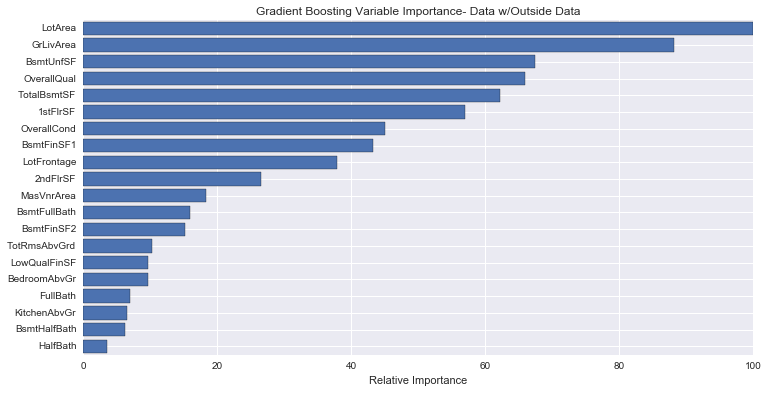

In [111]:
feature_importance = GBmodel.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
feature_importance = feature_importance[:20]
#print feature_importance
sorted_idx = np.argsort(feature_importance)
#sorted_idx = sorted_idx
#print sorted_idx
list_columns=list(X.columns.values)

pos = np.arange(sorted_idx.shape[0]) + .5

feature_names=[]
for i in range(len(sorted_idx)):
    feature_names.append(list_columns[sorted_idx[i]])
#print feature_names
#print feature_importance[sorted_idx]
#plt.subplot(1, 2, 2)
plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names)

plt.xlabel('Relative Importance')
plt.title('Gradient Boosting Variable Importance- Data w/Outside Data')
plt.show()

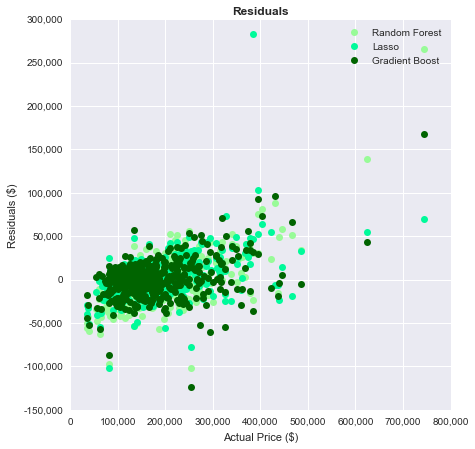

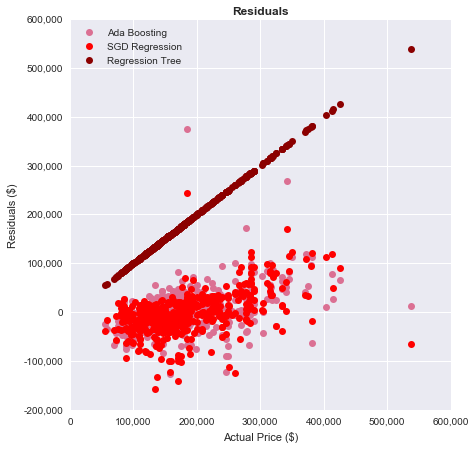

In [112]:
## Best
BMresiduals_RANDFOR_reg=y_test-p_rf2_reg
BMresiduals_LASSO_scalelog=y_test-np.exp(lasso_predict_scalelog)
BMresiduals_GRADBOOST_reg=y_test-p_gb1_reg

# Plot Residuals - Best Models
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121)
ax1.plot(y_test,BMresiduals_RANDFOR_reg,"o",label='Random Forest',color='palegreen')
ax1.plot(y_test,BMresiduals_LASSO_scalelog,"o",label='Lasso',color='mediumspringgreen')
ax1.plot(y_test,BMresiduals_GRADBOOST_reg,"o",label='Gradient Boost', color='darkgreen')
ax1.legend(numpoints=1,loc='upper right')
ax1.set_ylabel('Residuals ($)')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_xlabel('Actual Price ($)')
ax1.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_title('Residuals', fontsize=12, fontweight='bold')

## Worst
WMresiduals_ADABOOST_scalelog=y_test-np.exp(GS_ADABOOST_predict_scalelog)
WMresiduals_SGD_reg=y_test-GSCV_SGDclf_predict_reg
WMresiduals_REGTREE_log=y_test=np.exp(p_tree2_scalelog)

# Plot Residuals - Worst Models
fig = plt.figure(figsize=(15, 7))
ax2 = fig.add_subplot(121)
ax2.plot(y_test,WMresiduals_ADABOOST_scalelog,"o",label='Ada Boosting',color='palevioletred')
ax2.plot(y_test,WMresiduals_SGD_reg,"o",label='SGD Regression',color='red')
ax2.plot(y_test,WMresiduals_REGTREE_log,"o",label='Regression Tree', color='darkred')
ax2.legend(numpoints=1,loc='upper left')
ax2.set_ylabel('Residuals ($)')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_xlabel('Actual Price ($)')
ax2.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_title('Residuals', fontsize=12, fontweight='bold')